In [1]:
import pandas as pd
import numpy as np
import janitor
import pickle
import datetime

import matplotlib.pyplot as plt
from matplotlib.collections import EllipseCollection
from matplotlib.colors import ListedColormap
import seaborn as sns


In [2]:
with open('data/dataframe.pkl', 'rb') as file:
    df = pickle.load(file)

with open('data/measurement_units.pkl', 'rb') as file:
    measurement_units = pickle.load(file)


In [3]:
nrow, ncol = df.shape

print(f'{nrow=}')
print(f'{ncol=}')


nrow=39000
ncol=15


In [4]:
df.dtypes


factor
co       float64
no       float64
no2      float64
nox      float64
o3       float64
pm10     float64
pm2_5    float64
so2      float64
prs      float64
rainf    float64
rh       float64
sr       float64
tout     float64
wdr      float64
wsr      float64
dtype: object

In [5]:
df.isna().any()


factor
co       True
no       True
no2      True
nox      True
o3       True
pm10     True
pm2_5    True
so2      True
prs      True
rainf    True
rh       True
sr       True
tout     True
wdr      True
wsr      True
dtype: bool

In [6]:
df.describe().T


,count,mean,std,min,25%,50%,75%,max
factor,,,,,,,,
co,29929.0,1.680407,1.026028,0.010,0.800,1.500,2.390,5.790
no,31698.0,9.119481,8.919118,0.500,3.200,8.200,11.000,161.000
no2,32587.0,11.030659,7.882015,0.100,5.700,8.800,14.300,82.300
nox,32603.0,19.730884,13.365144,0.500,12.300,16.900,23.300,198.200
o3,37916.0,25.394978,19.094151,1.000,10.000,22.000,35.000,153.000
pm10,36918.0,60.000271,35.893426,2.000,37.000,52.000,75.000,714.000
pm2_5,20455.0,18.930229,13.211835,2.000,9.000,16.000,25.000,156.000
so2,29446.0,4.205556,2.241917,0.500,2.900,3.600,4.800,67.400
prs,38526.0,713.374157,1.658740,702.400,712.300,713.200,714.300,738.900


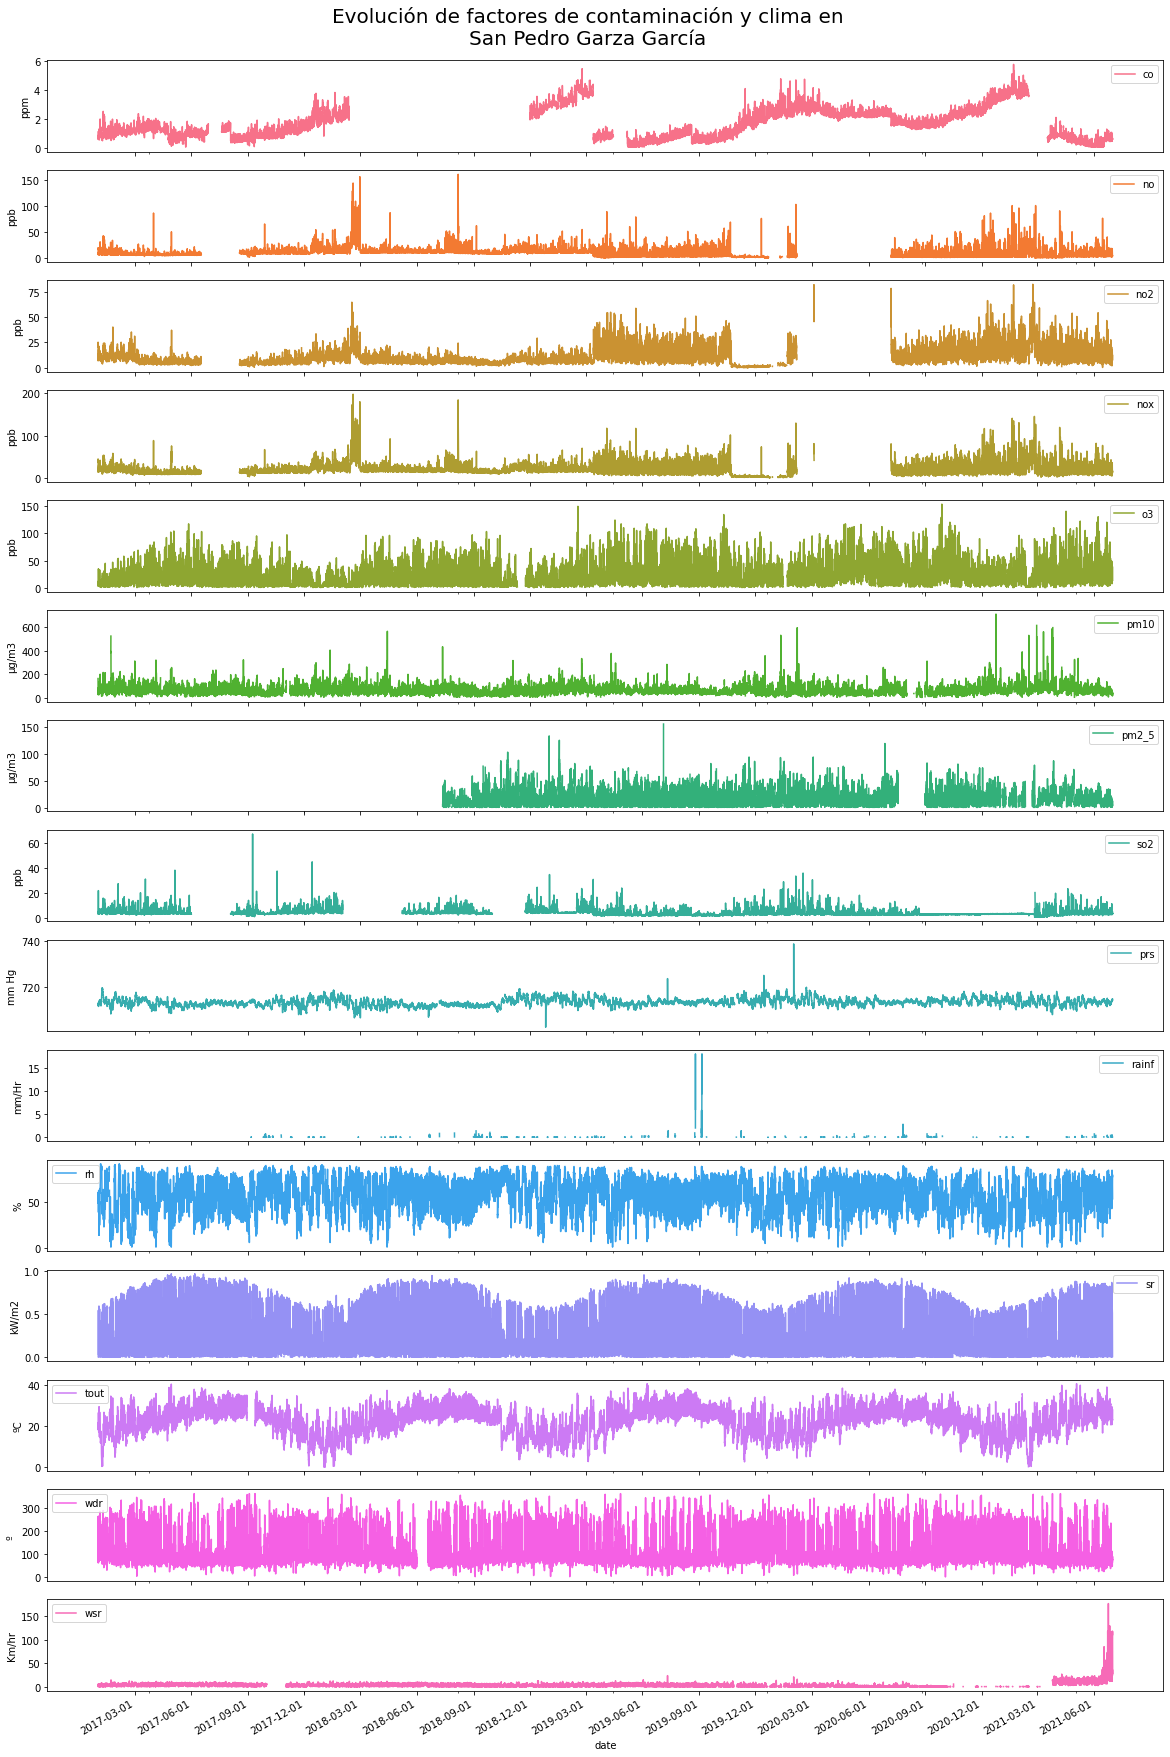

In [7]:
palette = sns.husl_palette(n_colors=15)

kwargs = {'subplots': True,
          'figsize': (20, 30),
          'sharex': True,
          'xticks': pd.date_range(df.index.min(), df.index.max(), freq='Q').strftime("%Y-%b").tolist(),
          'colormap': ListedColormap(palette.as_hex())
          }

axes = df.plot(**kwargs)

for ax in axes:
    factor = ax.get_legend().get_texts()[0]._text
    ax.set_ylabel(measurement_units[factor])

fig = axes[0].get_figure()  # All Axes contain the 15 subplots as figure
_ = fig.suptitle(
    'Evolución de factores de contaminación y clima en\nSan Pedro Garza García', fontsize=20)
fig.subplots_adjust(top=0.955)


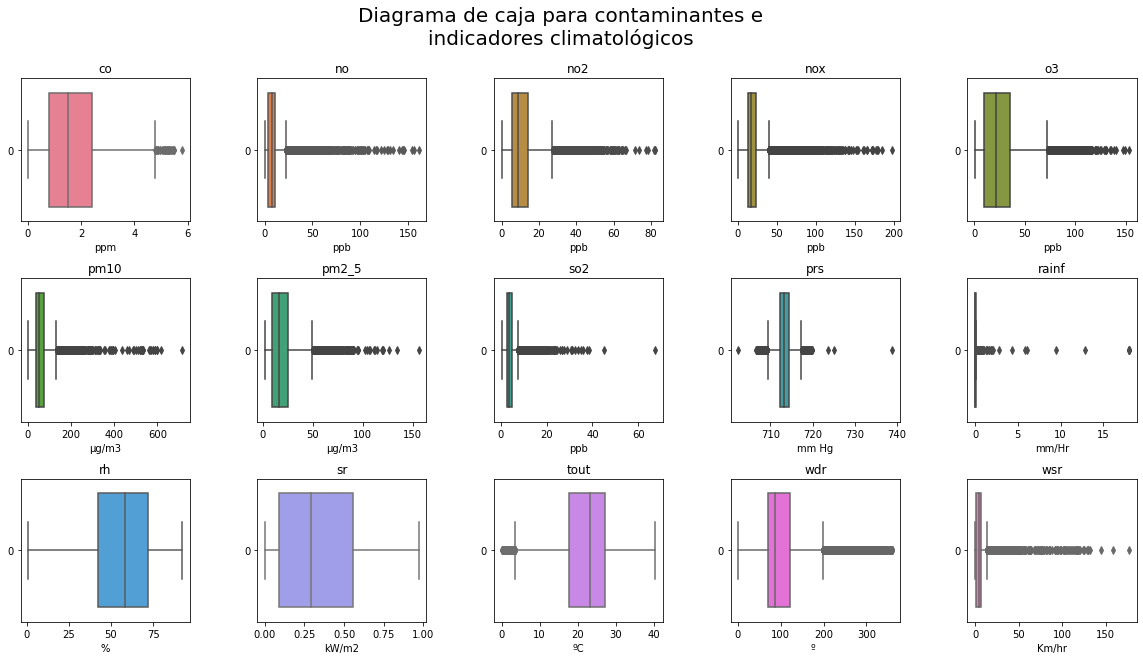

In [8]:
fig, axes = plt.subplots(3, 5, figsize=(20, 10),
                         gridspec_kw={'hspace': 0.4, 'wspace': 0.4})

iter_palette = iter(palette)

for i in range(3):
    for j in range(5):
        factor = df.iloc[:, i*5 + j]
        sns.boxplot(data=factor, ax=axes[i, j],
                    orient='h', color=next(iter_palette))
        axes[i, j].set_title(factor.name)
        axes[i, j].set_xlabel(measurement_units[factor.name])
        

_ = fig.suptitle(
    'Diagrama de caja para contaminantes e\nindicadores climatológicos', fontsize=20)


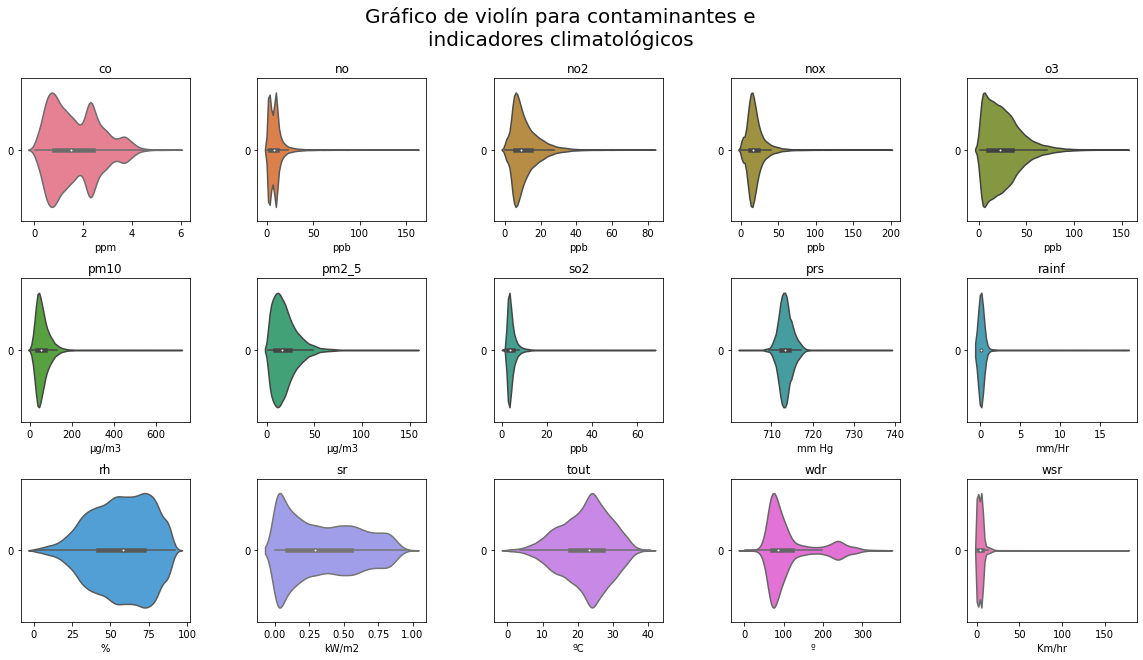

In [9]:
fig, axes = plt.subplots(3, 5, figsize=(20, 10),
                         gridspec_kw={'hspace': 0.4, 'wspace': 0.4})

iter_palette = iter(palette)

for i in range(3):
    for j in range(5):
        factor = df.iloc[:, i*5 + j]
        sns.violinplot(data=factor, ax=axes[i, j], orient='h',
                       color=next(iter_palette))
        axes[i, j].set_title(factor.name)
        axes[i, j].set_xlabel(measurement_units[factor.name])

_ = fig.suptitle(
    'Gráfico de violín para contaminantes e\nindicadores climatológicos', fontsize=20)


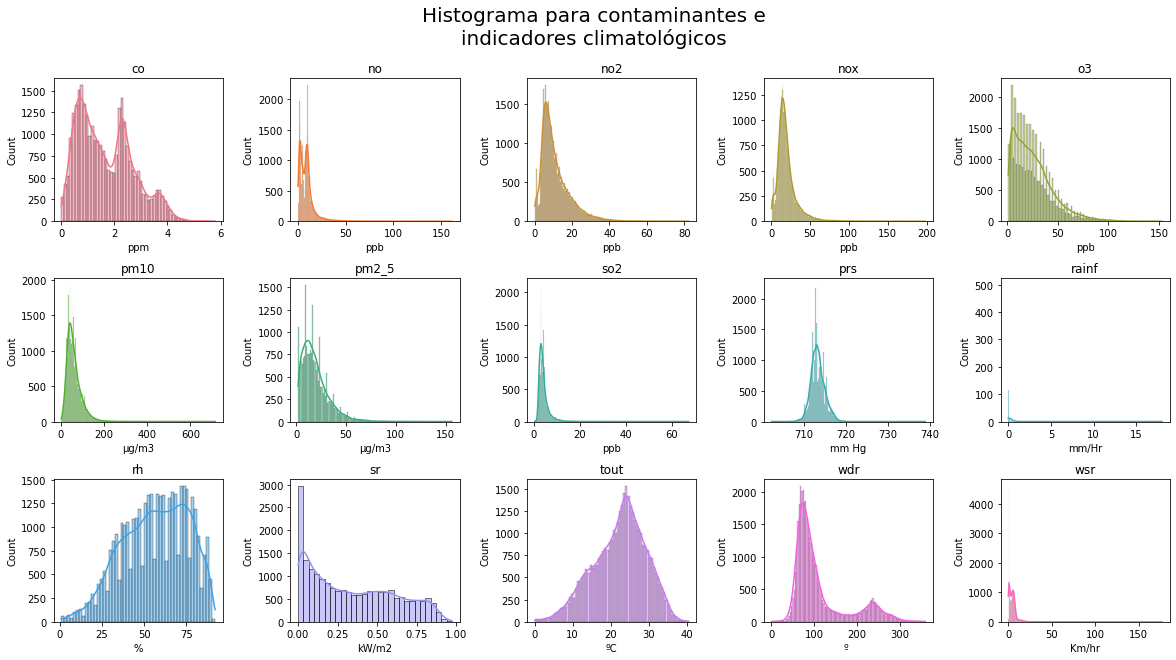

In [10]:
fig, axes = plt.subplots(3, 5, figsize=(20, 10),
                         gridspec_kw={'hspace': 0.4, 'wspace': 0.4})

iter_palette = iter(palette)

for i in range(3):
    for j in range(5):
        factor = df.iloc[:, i*5 + j]
        sns.histplot(data=factor, ax=axes[i, j],
                     kde=True, color=next(iter_palette))
        axes[i, j].set_title(factor.name)
        axes[i, j].set_xlabel(measurement_units[factor.name])

_ = fig.suptitle(
    'Histograma para contaminantes e\nindicadores climatológicos', fontsize=20)


In [11]:
def plot_corr_ellipses(data, ax, **kwargs):

    m = np.array(data)
    xy = np.indices(m.shape)[::-1].reshape(2, -1).T
    w = np.ones_like(m).ravel()
    h = 1 - np.abs(m).ravel()
    a = 45 * np.sign(m).ravel()

    ec = EllipseCollection(widths=w, heights=h, angles=a, units='x', offsets=xy,
                           transOffset=ax.transData, array=m.ravel(), **kwargs)
    ax.add_collection(ec)

    if isinstance(data, pd.DataFrame):
        ax.set_xticks(np.arange(m.shape[1]))
        ax.set_xticklabels(data.columns, rotation=90)
        ax.set_yticks(np.arange(m.shape[0]))
        ax.set_yticklabels(data.index)

    return ec


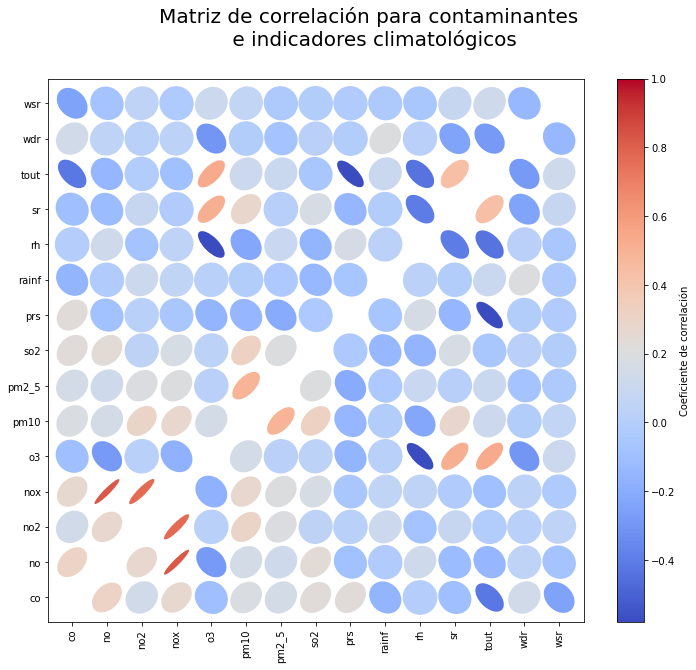

In [12]:
fig, ax = plt.subplots(figsize=(12, 10))
_ = fig.suptitle(
    'Matriz de correlación para contaminantes \n e indicadores climatológicos', fontsize=20)
m = plot_corr_ellipses(df.corr(), ax=ax, cmap='coolwarm')
cb = fig.colorbar(m)
cb.set_label('Coeficiente de correlación')
ax.margins(0.05)


### Outlier procedures

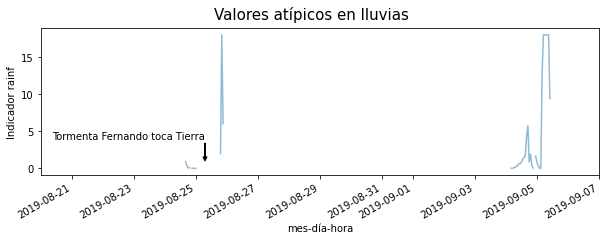

In [13]:
fig, ax = plt.subplots(figsize=(10, 3))
ax = df.rainf.plot(color='#92BAD2')

# Zoom in September 2019
_ = ax.set_xlim(['8-20-2019', '9-7-2019'])

occurence = {'date': datetime.datetime(2019, 8, 25, 7),
             'event': 'Tormenta Fernando toca Tierra'}
_ = ax.annotate(occurence['event'], xy=(occurence['date'], df.rainf.asof(occurence['date']) + 1),
                xytext=(occurence['date'],
                        df.rainf.asof(occurence['date']) + 5),
                arrowprops=dict(facecolor='black', headwidth=4, width=1,
                                headlength=4),
                horizontalalignment='right', verticalalignment='top')

_ = ax.set_xlabel('mes-día-hora')
_ = ax.set_ylabel('Indicador rainf')
_ = fig.suptitle('Valores atípicos en lluvias', fontsize=15)


Los valores atípicos fueron causados por una tormenta, se revisará si esta tuvo un impacto severo en las demás variables, si no es el caos, se eliminarán estos valores expremos y se  reemplazaron los valores faltantes con cero. 

TypeError: '>' not supported between instances of 'numpy.ndarray' and 'str'

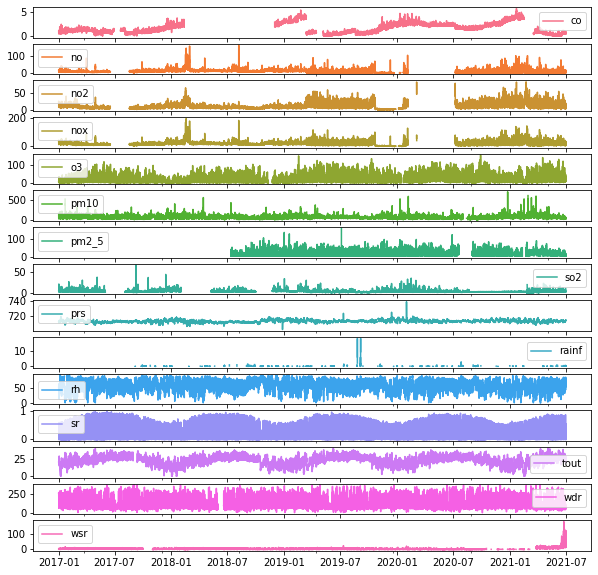

In [14]:
palette = sns.husl_palette(n_colors=15)

kwargs = {'subplots': True,
          'figsize': (10, 10),
          'sharex': True,
          'xlim': ['8-20-2019', '9-7-20s19'],
          'colormap': ListedColormap(palette.as_hex())
          }

axes = df.plot(**kwargs)

for ax in axes:
    factor = ax.get_legend().get_texts()[0]._text
    ax.set_ylabel(measurement_units[factor])

fig = axes[0].get_figure()  # All Axes contain the 15 subplots as figure
_ = fig.suptitle(
    'Evolución de factores de contaminación y clima en\nSan Pedro Garza García durante la tormeta Fernando', fontsize=15)
fig.subplots_adjust(top=0.925)


No hubo una alza en los contaminantes ni en otros factores meteorológicos, es seguro eliminar estos valores atípicos y proceder con un método general para las demás variables

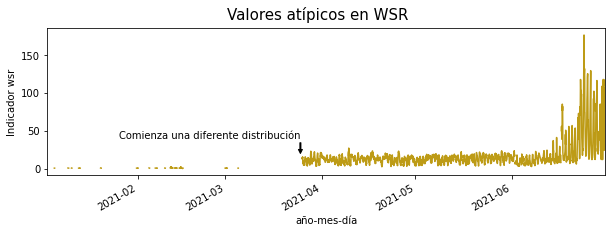

In [ ]:
fig, ax = plt.subplots(figsize=(10, 3))
ax = df.wsr.plot(color='#BD9B16')

# Zoom in april 2021
_ = ax.set_xlim(['1-3-2021', df.index.max()])

occurence = {'date': datetime.datetime(2021, 3, 25, 4),
             'event': 'Comienza una diferente distribución'}

_ = ax.annotate(occurence['event'], xy=(occurence['date'], df.rainf.asof(occurence['date']) + 20),
                xytext=(occurence['date'],
                        df.rainf.asof(occurence['date']) + 50),
                arrowprops=dict(facecolor='black', headwidth=4, width=1,
                                headlength=4),
                horizontalalignment='right', verticalalignment='top')

_ = ax.set_xlabel('año-mes-día')
_ = ax.set_ylabel('Indicador wsr')
_ = fig.suptitle('Valores atípicos en WSR', fontsize=15)


Se desconoce el porqué de esta diferencia en la toma de datos, se cree que ocurrió alguna falla técnica dentro del sensor, ya que las mediciones no se asemejan de ninguna manera a lo recabado en los años anteriores. Se eliminarán los valores a partir de esta fecha, debido a la alta incertidumbre que se tiene

In [ ]:
df = (
      df
      .pipe(janitor.transform_column, column_name='rainf',
            function=lambda rainf: rainf.where(
                  (rainf.index < '2019-8-25') | (rainf.index > '2019-9-6'), np.nan),
            elementwise=False)
      .pipe(janitor.transform_column, column_name='wsr',
            function=lambda wsr: wsr.where(wsr.index < '2021-3-23', np.nan),
            elementwise=False)
)


In [ ]:
limits = pd.Series({
    'co': 26,
    'no': 210,
    'no2': 210,
    'nox': 210,
    'o3': 90,
    'pm10': 70,
    'pm2_5': 41,
    'so2': 75,
    'prs': 760,
    'rainf': 130,
    'rh': 100,
    'sr': 1,
    'tout': 45,
    'wdr': 360,
    'wsr': 117,
}) # Maximum value that variables can take according to the Mexican normatives of air quality

In [ ]:
df = df.apply(lambda row: row.where(row < limits, np.nan), axis=1)

### Imputation

In [ ]:
with open('data/centro.pkl', 'rb') as file:
    centro = pickle.load(file)

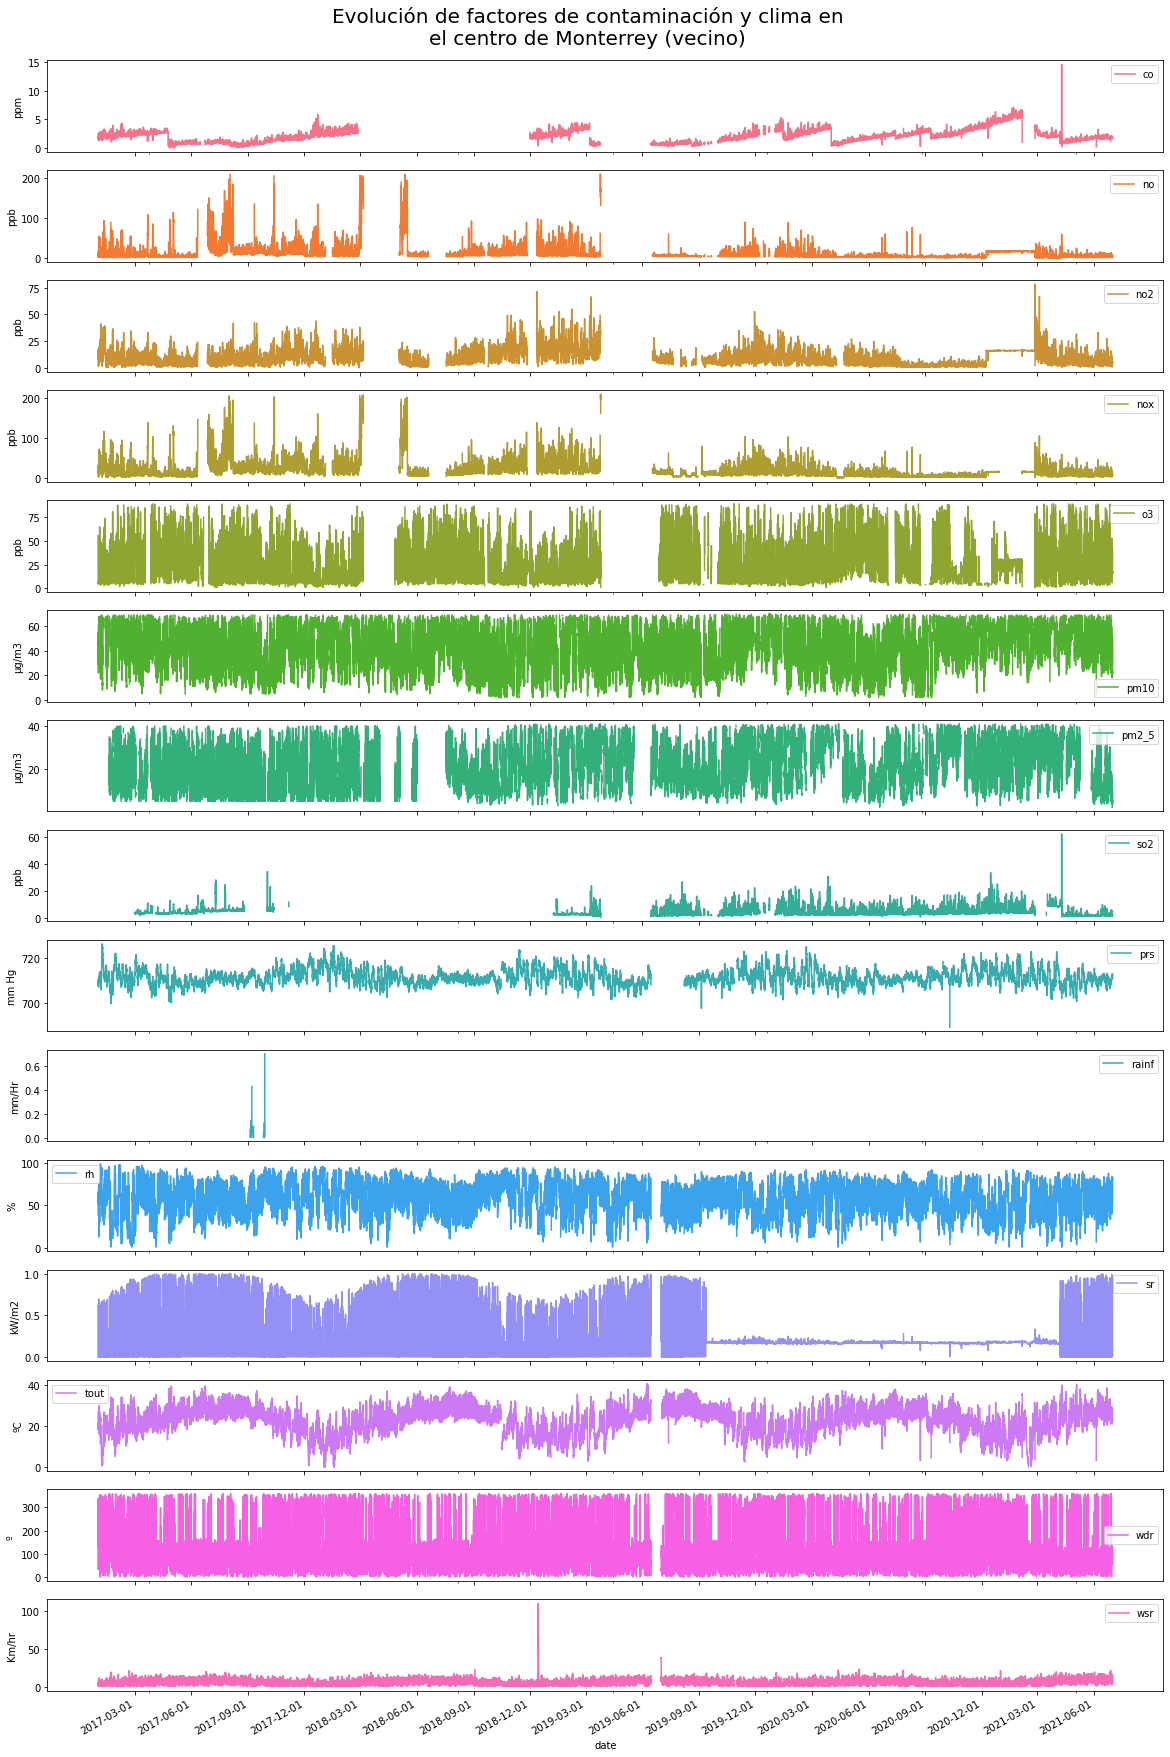

In [ ]:
palette = sns.husl_palette(n_colors=15)

kwargs = {'subplots': True,
          'figsize': (20, 30),
          'sharex': True,
          'xticks': pd.date_range(df.index.min(), df.index.max(), freq='Q').strftime("%Y-%b").tolist(),
          'colormap': ListedColormap(palette.as_hex())
          }

axes = centro.plot(**kwargs)

for ax in axes:
    factor = ax.get_legend().get_texts()[0]._text
    ax.set_ylabel(measurement_units[factor])

fig = axes[0].get_figure()  # All Axes contain the 15 subplots as figure
_ = fig.suptitle(
    'Evolución de factores de contaminación y clima en\nel centro de Monterrey (vecino)', fontsize=20)
fig.subplots_adjust(top=0.955)


In [ ]:
centro = centro.apply(lambda row: row.where(row < limits, np.nan), axis=1)

In [ ]:
sp = (
    # Temporary code
    df
    .pipe(janitor.fill_empty, column_names='pm2_5', value=centro[centro.index < '2018-07-13'].pm2_5) # Replacement with centro
    .pipe(janitor.fill_empty, column_names='no', value=centro[(centro.index > '2020-02-05') & (centro.index < '2020-07-7')].no) # same 
    .pipe(janitor.fill_empty, column_names='no2', value=centro[(centro.index > '2020-02-05') & (centro.index < '2020-07-7')].no2) # same
    .pipe(janitor.fill_empty, column_names='nox', value=centro[(centro.index > '2020-02-05') & (centro.index < '2020-07-7')].nox) # same
    .pipe(janitor.fill_empty, column_names='rainf', value=0) # it was not raining
    .pipe(janitor.fill_empty, column_names='o3', value=df.o3.rolling(250, min_periods=1).mean()) # Effective in a sense
    .pipe(janitor.fill_empty, column_names='pm10', value=df.pm10.rolling(250, min_periods=1).mean()) # Effective in a sense
    #.interpolate(method='time')
    #.pipe(janitor.fill_empty, colum_names='wdr', value=)
    #.pipe(janitor.fill_empty, colum_names='wdr', value=)
)


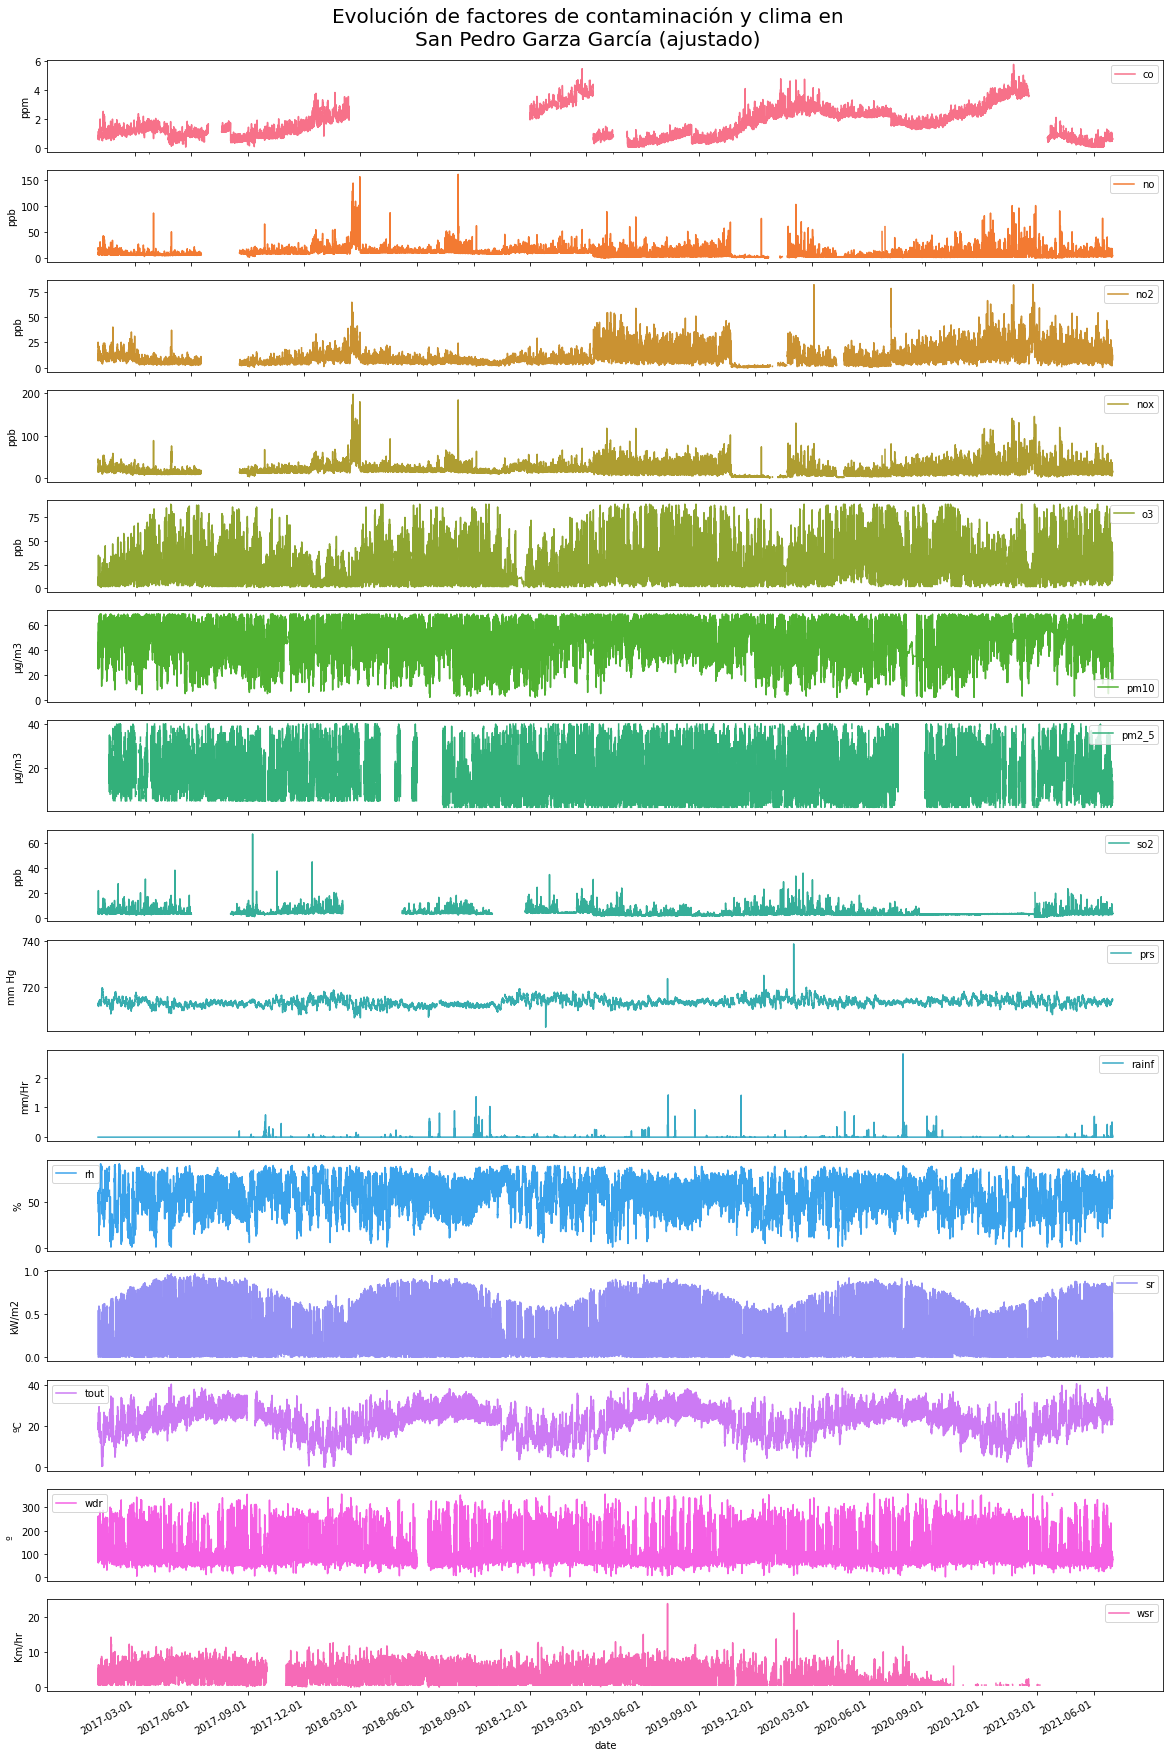

In [ ]:
palette = sns.husl_palette(n_colors=15)

kwargs = {'subplots': True,
          'figsize': (20, 30),
          'sharex': True,
          'xticks': pd.date_range(df.index.min(), df.index.max(), freq='Q').strftime("%Y-%b").tolist(),
          'colormap': ListedColormap(palette.as_hex())
          }

axes = sp.plot(**kwargs)

for ax in axes:
    factor = ax.get_legend().get_texts()[0]._text
    ax.set_ylabel(measurement_units[factor])

fig = axes[0].get_figure()  # All Axes contain the 15 subplots as figure
_ = fig.suptitle(
    'Evolución de factores de contaminación y clima en\nSan Pedro Garza García (ajustado)', fontsize=20)
fig.subplots_adjust(top=0.955)
